In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools

from scipy import ndimage

In [2]:
def star_footprint(ft, zshape):
    foo = int(np.round(zshape[0]/zshape[1]))
    footprint = np.zeros((ft, ft*foo), dtype=bool)
    for i in range( (ft-1)//2):
        s_ = np.s_[(foo*(i+1)):(foo*ft - foo*(i+1))]
        j = (ft-1)//2 - i - 1
        footprint[j, s_] = True
        footprint[-(j+1), s_] = True
    footprint[(ft-1)//2] = True
    return footprint

In [3]:
datafilename = '../data/zscore.csv'
data = pd.read_csv(datafilename)
print(data.shape)
columns = data.columns[2:]
columns = ['Unnamed: 0','Unnamed: 1'] + sorted(columns)
zscores = data.iloc[:, 2:].values
vmin = zscores.min()
vmax = zscores.max()
data.head()

(2335, 159)


,Unnamed: 0,Unnamed: 1,secoti.13_Endosperm,sheart.14_Endosperm,root3_Epidermis_RH,root4_Epidermis,sami10_Shoot_meristematic_cells,noduled_Sclereid_layer,sami20_Unknown,sami19_Unknown,...,root1_Epiermis,root7_Cortex,root2_Epidermis,root8_Cortex,root9_Cortex,nodulee_Vascular_bundle,nodulei_Stressed_cells,nodulea_Inner_outer_cortex,noduleb_Inner_outer_cortex,nodulec_vascular_endodermis
0,GLYMA_10G048900,NF-YB,1.113600,2.602320,-0.758987,4.228068,6.928475,-0.758987,-0.758987,-0.758987,...,-0.258661,-0.758987,0.012567,-0.758987,-0.164514,-0.758987,-0.758987,-0.173329,-0.758987,-0.758987
1,GLYMA_18G262800,ERF,0.747721,0.175768,3.575354,-0.345157,6.906796,-0.345157,-0.345157,-0.345157,...,-0.345157,-0.345157,-0.345157,-0.345157,-0.345157,-0.345157,-0.345157,-0.345157,-0.345157,-0.345157
2,GLYMA_18G004700,MICK-MADS,0.124140,-0.113325,-0.532260,-0.548094,7.328576,-0.548094,-0.334433,-0.548094,...,-0.548094,-0.548094,-0.548094,-0.548094,-0.548094,-0.548094,-0.548094,-0.548094,-0.548094,-0.548094
3,GLYMA_11G252300,MICK-MADS,0.236485,-0.023550,-0.571694,-0.571694,5.796316,-0.571694,-0.571694,-0.571694,...,-0.571694,-0.571694,-0.571694,-0.571694,-0.571694,-0.571694,-0.571694,-0.571694,-0.571694,-0.571694
4,GLYMA_14G050000,C3H,-0.302370,-0.203989,-0.296758,-0.142447,8.470721,-0.717041,-0.487026,0.110139,...,-0.165146,-0.439803,-0.317370,-0.077606,-0.412691,-0.099476,-0.717041,-0.644871,-0.446279,0.397388


In [4]:
size = 11
zthr = 5
zmask0 = np.zeros(zscores.shape, dtype=bool)
zmask0[zscores > zthr] = True

#zmask = ndimage.grey_dilation(zmask0, size=(size,1), mode='constant', cval=vmin)
#zmask = ndimage.grey_erosion(zmask, size=(size,1), mode='constant', cval=vmax+1)
#zmask = ndimage.grey_dilation(zmask, size=(2,1), mode='constant', cval=vmin)

zmask = zmask0.copy()

label, num = ndimage.label(zmask, structure=[[0,1,0],[0,1,0],[0,1,0]])
css = ndimage.find_objects(label)
hist, bins = np.histogram(label.ravel(), bins=range(1,num+2))
print(num,'components')

1368 components


In [5]:
boxlims = np.array([ [s[0].start, s[0].stop, s[1].start, s[1].stop] for s in css ])
boxlims = np.column_stack((boxlims, hist))
boxes = pd.DataFrame(boxlims, columns=['top','bottom','left','right', 'size'])
boxes = boxes.sort_values(by='size', ascending=False)
boxes

,top,bottom,left,right,size
51,85,181,1,2,96
832,1422,1492,152,153,70
55,96,150,0,1,54
871,1532,1585,154,155,53
1127,1925,1976,2,3,51
...,...,...,...,...,...
635,1120,1121,51,52,1
637,1122,1123,51,52,1
638,1124,1125,111,112,1
639,1125,1126,99,100,1


In [6]:
htrack = np.full(len(zscores), np.nan)
keep = []

for k in range(len(boxes)):
    lims = boxes.iloc[k].values
    if np.all(np.isnan(htrack[lims[0]:lims[1]])):
        htrack[lims[0]:lims[1]] = range(lims[0], lims[1])
        keep.append(boxes.iloc[k].name)

keep = np.array(keep)
len(keep)

485

In [7]:
bxs = boxes.loc[keep].sort_values(by='left')
argsort = np.array([], dtype=int)
for i in range(len(bxs)):
    lims = bxs.iloc[i].values
    argsort = argsort = np.hstack((argsort, range(lims[0], lims[1])))

In [8]:
redo = np.setdiff1d(range(len(zscores)), argsort)
ag = np.hstack((argsort, redo))
ag.shape

(2335,)

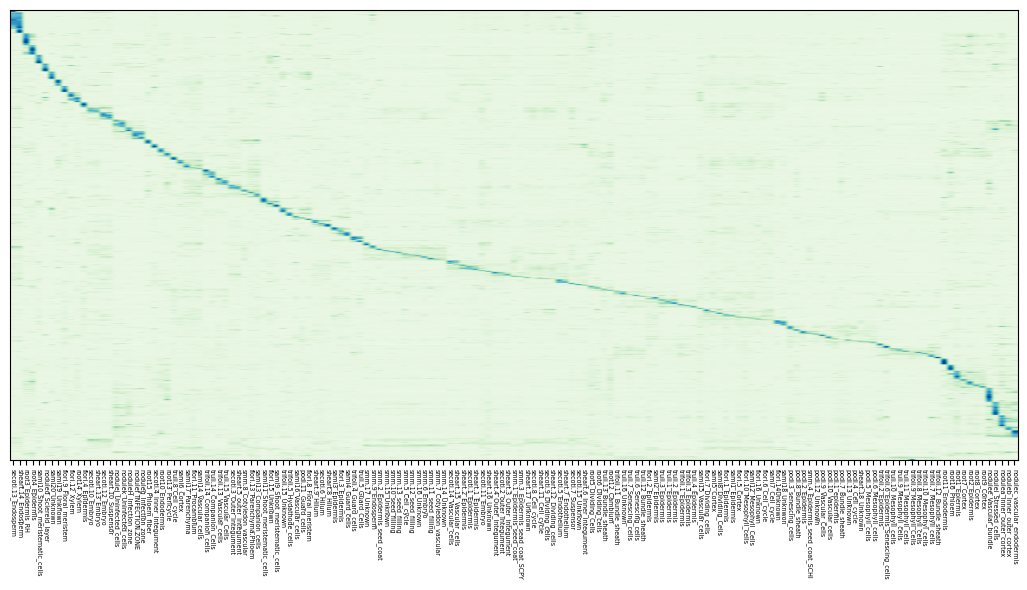

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(zscores[ag], cmap='GnBu')
ax[i].set_xticks(range(zscores.shape[1]), data.columns[2:], fontsize=5, rotation=270, fontstretch='ultra-condensed')
i += 1
#ax[i].imshow(zmask[ag], cmap='GnBu')

for i in range(len(ax)):
    #ax[i].axhline(len(argsort), c='r', lw=0.5)
    #ax[i].axvline(145, c='b', lw=0.5)
    #ax[i].axvline(152, c='b', lw=0.5)
    ax[i].tick_params(left=False, labelleft=False)
    ax[i].set_aspect(0.03)
    ax[i].margins(0)

fig.tight_layout();
filename = '../data/zscores_resorted'
dpi = 2400
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight', dpi=dpi)
#plt.savefig(filename + '.png', format='png', bbox_inches='tight', dpi=dpi)
plt.savefig(filename + '.jpg', format='jpg', bbox_inches='tight', dpi=dpi)

In [42]:
data.loc[ag].to_csv(filename + '.csv', index=False)